In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [2]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [3]:
# Shuffle data set
indices = np.array(range(len(X)))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

X_train -= 127
X_train /= 127

X_test -= 127
X_test /= 127

In [4]:
X_test.shape
y.shape

(42000, 1)

In [5]:
import tensorflow as tf

def dense(input_size, output_size, mean=0.0, stddev=0.01, dtype=tf.float32, activation_type=None):
    weight_tensor = tf.Variable(tf.random_normal(shape=(input_size, output_size),
                                                mean=mean, stddev=stddev, dtype=dtype))
    
    bias_tensor = tf.Variable(tf.zeros(output_size))
    
    def apply_dense(X, keep_prob):
        result = tf.add(tf.matmul(X, weight_tensor), bias_tensor)
        return tf.layers.dropout(activation_type(result), rate=1-keep_prob, training=True) if activation_type != None else result

    return apply_dense
        

/home/safwan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
def combine(tensor_one, tensor_two):
    return tf.div(tf.add(tensor_one, tensor_two), 2)

In [7]:
input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))
learning_rate_ph = tf.placeholder(dtype=tf.float32)
keep_prob = tf.placeholder(dtype=tf.float32)

In [8]:
def nn():
    
    l1 = dense(int(input_.shape[1]), 1024, activation_type=tf.nn.relu)(input_, keep_prob)
    l2 = dense(int(l1.shape[1]), 256, activation_type=tf.nn.relu)(l1, keep_prob)
    l3 = dense(int(l2.shape[1]), 64, activation_type=tf.nn.relu)(l2, keep_prob)
    
    #l4 = combine(l1, l3)
    l5 = dense(int(l3.shape[1]), 32, activation_type=tf.nn.relu)(l3, keep_prob)
    
    l6 = dense(int(l5.shape[1]), 64, activation_type=tf.nn.relu)(l5, keep_prob)
    
    #l7 = combine(l2,l6)
    
    l8 = dense(int(l6.shape[1]), 64, activation_type=tf.nn.relu)(l6, keep_prob)
    l9 = dense(int(l8.shape[1]), 64, activation_type=tf.nn.relu)(l8, keep_prob)
    
    #l10 = combine(l8,l9)
    
    out = dense(int(l3.shape[1]), 10)(l3, keep_prob)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return cost, optimizer, out

In [9]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [10]:
cost, optimizer, output = nn()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
from sklearn.metrics import accuracy_score

# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 1500
batch_size = 100
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []
test_accuracy = []
cost_curr = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #graph = tf.get_default_graph().as_graph_def()
    #print([n for n in graph.node])
    
    #plt.ion()
    # Training cycle
    current_placeholder_value = 0.0001
    
    for epoch in range(epochs):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={input_:x, labels:y, learning_rate_ph:current_placeholder_value, keep_prob:1.0})
        
        if epoch > 0 and  epoch % 25 == 0:
            c = sess.run(cost, feed_dict={input_: x, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            
            # Find train accuracy
            y_predicted_train_fold = np.argmax(output.eval(feed_dict={input_: X_train_fold, labels: y_train_fold, learning_rate_ph:current_placeholder_value, keep_prob:1.0}), 1)
            current_train_acc = accuracy_score(y_true=y_train_fold, y_pred=y_predicted_train_fold)

            train_accuracy.append(current_train_acc)



            # Find the validation accuracy
            y_predicted_val_fold = np.argmax(output.eval(feed_dict={input_: X_val_fold, labels: y_val_fold, learning_rate_ph:current_placeholder_value, keep_prob:1.0}), 1)
            current_val_acc = accuracy_score(y_true=y_val_fold, y_pred=y_predicted_val_fold)

            val_accuracy.append(current_val_acc)
            cost_curr.append(c)

            # Find test accuracy.
            y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test, keep_prob:1.0}), 1)

            test_acc = accuracy_score(y_true=y_test, y_pred=y_predicted_test)
            test_accuracy.append(test_acc)
            print("Train Accuracy:", current_train_acc)
            print("Validation Accuracy:", current_val_acc)
            print("Test Accuracy:",test_acc)
            print()
            
            # Save the model
            saver = tf.train.Saver()
            saver.save(sess, './MNIST_MODEL_FC', global_step=500)
    
    print("Optimization Finished!")
    
    
    # Find test accuracy
    y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test, keep_prob:1.0}), 1)
    print("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_predicted_test))

Epoch: 0026 cost= 0.013589566
Train Accuracy: 0.9010161996683532
Validation Accuracy: 0.905952380952381
Test Accuracy: 0.90135703515594

Epoch: 0051 cost= 0.004329106
Train Accuracy: 0.925294442790935
Validation Accuracy: 0.9212585034013605
Test Accuracy: 0.9194508372351401

Epoch: 0076 cost= 0.002738221
Train Accuracy: 0.9188741017900421
Validation Accuracy: 0.9188775510204081
Test Accuracy: 0.9108800888818348

Epoch: 0101 cost= 0.002020458
Train Accuracy: 0.9480420085888005
Validation Accuracy: 0.9518707482993197
Test Accuracy: 0.9369891278469963

Epoch: 0126 cost= 0.000961743
Train Accuracy: 0.9519537395297419
Validation Accuracy: 0.948469387755102
Test Accuracy: 0.942623601301484

Epoch: 0151 cost= 0.000819490
Train Accuracy: 0.9508057315362047
Validation Accuracy: 0.9532312925170068
Test Accuracy: 0.9415125783667962

Epoch: 0176 cost= 0.000794826
Train Accuracy: 0.9647093839023768
Validation Accuracy: 0.964625850340136
Test Accuracy: 0.9513530672168875

Epoch: 0201 cost= 0.0013351

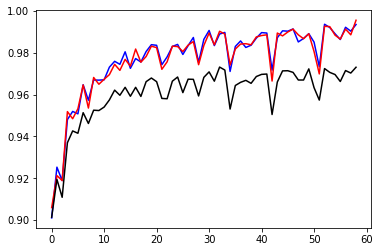

In [12]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-', test_accuracy, 'k-')
plt.show()

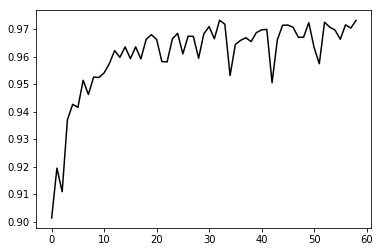

In [13]:
plt.plot(test_accuracy,'k-')
plt.show()

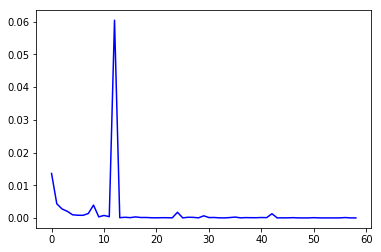

In [14]:
plt.plot(cost_curr, 'b-')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

array([[1231,    0,    1,    2,    0,    1,    8,    2,    2,    3],
       [   0, 1432,    2,    1,    1,    1,    1,    0,    4,    1],
       [   2,    9, 1147,    6,    3,    2,    5,    2,    2,    1],
       [   1,    0,   13, 1221,    0,   15,    0,    2,   10,    5],
       [   0,    1,    1,    0, 1176,    0,    3,    1,    0,   20],
       [   5,    1,    3,    7,    2, 1138,    5,    0,    8,    1],
       [   3,    0,    0,    0,    3,    2, 1310,    0,    1,    0],
       [   2,   12,   15,    4,    5,    1,    0, 1259,    2,   17],
       [   2,    3,    5,    5,    4,    4,    3,    0, 1176,    3],
       [   6,    0,    0,    5,   16,    4,    0,    9,    5, 1204]])

In [16]:
indices = np.where(np.logical_and(y_predicted_test == 3, y_test.squeeze() == 4))[0]
for i in indices:
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()

In [17]:
import pandas as pd
from numpy import genfromtxt

# Load actual test data
dataframe = genfromtxt('test.csv', delimiter=',', skip_header=True)

y_true_test, X_true_test = dataframe[:,0], dataframe[:, :]
y_true_test = y_true_test.reshape([-1,1])

# Normalize the data
X_true_test -= 127
X_true_test /= 127

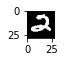

[-1.]


In [18]:
import matplotlib.pyplot as plt

# print(X_true_test[0].reshape([28,28]))
plt.figure(figsize=(0.50,0.50))
plt.imshow(X_true_test[0].reshape([28,28]),cmap='gray')
plt.show()
print(y_true_test[0])

In [19]:
#print(tf.trainable_variables())

In [20]:
import tensorflow as tf
import numpy as np

#init = tf.global_variables_initializer()

# Load the saved model
with tf.Session() as sess:
    #sess.run(init)
    
    #model = tf.train.import_meta_graph('./MNIST_MODEL_FC.meta')
    #model.restore(sess, tf.train.latest_checkpoint('./'))
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # Find final test accuracy
    y_final_predicted_test = np.argmax(output.eval(feed_dict={input_: X_true_test, keep_prob:1.0}), 1)
    # Write predicted values to file in csv format
    out_index = np.array(list(range(1,len(y_final_predicted_test)+1)))
    data = pd.DataFrame({'Label': y_final_predicted_test})
    
    # Start index from 1
    data.index += 1
    data.to_csv('./predictions.csv', index_label=['ImageId'])

INFO:tensorflow:Restoring parameters from ./MNIST_MODEL_FC-500


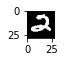

2


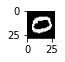

0


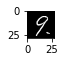

9


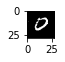

9


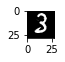

3


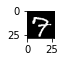

7


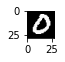

0


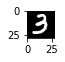

3


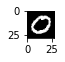

0


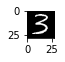

3


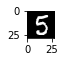

5


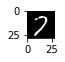

7


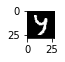

4


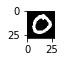

0


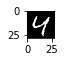

4


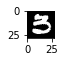

3


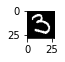

3


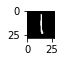

1


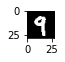

9


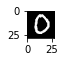

0


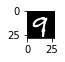

9


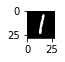

1


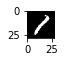

1


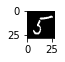

5


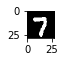

7


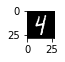

4


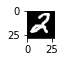

2


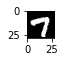

7


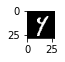

4


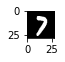

7


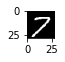

7


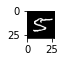

5


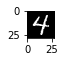

4


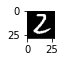

2


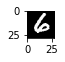

6


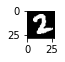

2


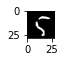

5


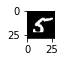

5


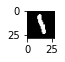

1


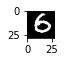

6


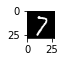

7


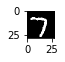

7


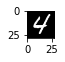

4


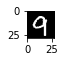

9


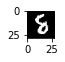

8


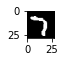

7


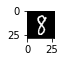

8


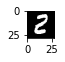

2


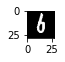

6


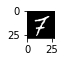

7


In [21]:
# print(X_true_test[0].reshape([28,28]))
for i in range(50):
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_true_test[i].reshape([28,28]),cmap='gray')
    plt.show()
    print(y_final_predicted_test[i])